In [1]:
import numpy as np
seed = 1234
np.random.seed(seed)
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
from tqdm import tqdm
import os

In [14]:
d = {'U925/U925_1deg_monq90_1940-2025':'U925_90', 
     'U925/U925_1deg_monq75_1940-2025':'U925_75', 
     'U925/U925_1deg_monq66_1940-2025':'U925_66', 
     'U925/U925_1deg_monmean_1940-2025':'U925_50', 
     'U925/U925_1deg_monq33_1940-2025':'U925_33', 
     'U925/U925_1deg_monq25_1940-2025':'U925_25',
     'U925/U925_1deg_monq10_1940-2025':'U925_10',
     'OHC_3m_1955-2025':'OHC',
     'HadISST/SST_1870-2024':'SST',
     }

dec_times = {'U925_90':True, 
             'U925_75':True, 
             'U925_66':True, 
             'U925_50':True, 
             'U925_33':True, 
             'U925_25':True, 
             'U925_10':True, 
             'OHC':False, 
             'SST':False}

arr_dict = {}
time_dict = {}
for item in tqdm(d):
    data_path = '/home/mmotame1/climate-research/DVAE/dvae/dataset/' + item + '.nc'
    file_data = xr.load_dataset(data_path, decode_times=dec_times[d[item]])
    if 'U925' in d[item]:
        arr_dict[d[item]] = file_data.U925.values
        time_dict[d[item]] = pd.to_datetime(file_data.time.values)
    elif 'OHC' in d[item]:
        arr_dict[d[item]] = file_data.OHC.values
        time_dict[d[item]] = file_data.time.values
    elif 'SST' in item:
        arr_dict[d[item]] = file_data.SST.values
        time_dict[d[item]] = file_data.time.values
        
print(arr_dict.keys())
print(time_dict.keys())
print(arr_dict['U925_90'].shape, arr_dict['OHC'].shape, arr_dict['SST'].shape)
print(time_dict['U925_90'].shape, time_dict['OHC'].shape, time_dict['SST'].shape)
    

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:07<00:00,  1.24it/s]

dict_keys(['U925_90', 'U925_75', 'U925_66', 'U925_50', 'U925_33', 'U925_25', 'U925_10', 'OHC', 'SST'])
dict_keys(['U925_90', 'U925_75', 'U925_66', 'U925_50', 'U925_33', 'U925_25', 'U925_10', 'OHC', 'SST'])
(1028, 180, 360) (281, 1, 180, 360) (1860, 180, 360)
(1028,) (281,) (1860,)


In [ ]:
arr_dict['SST'].shape

In [3]:
### Fix SST times
time_steps = pd.date_range(start='1869-12-15', periods=len(time_dict['SST']), freq='MS')
time_dict['SST'] = time_steps

## Interpolate OHC

In [ ]:
# Given: file_data.OHC.values is (T, H, W) and file_data.time.values is (T,)
# The times are 1,4,7,10,... (i.e., every 3), want to interpolate to all times 1,2,3,4,5,...

# Get the original time values (e.g., 1,4,7,...)
orig_times = np.floor(time_dict['OHC']).astype(float)  # shape (T,)
# If times are not already sorted, sort them and the data accordingly
sort_idx = np.argsort(orig_times)
orig_times = orig_times[sort_idx]
orig_data = arr_dict['OHC'][sort_idx].squeeze()  # shape (T, H, W)

# Determine the new time grid: from min to max, step 1
new_times = np.arange(int(orig_times[0]), int(orig_times[-1]) + 1)

# Reshape for interpolation: (T, H, W) -> (T, -1)
T, H, W = orig_data.shape
orig_data_flat = orig_data.reshape(T, -1)  # (T, H*W)

# Interpolate along the time axis for each pixel
interp_data_flat = np.empty((len(new_times), H*W), dtype=orig_data.dtype)
for i in range(orig_data_flat.shape[1]):
    interp_data_flat[:, i] = np.interp(new_times, orig_times, orig_data_flat[:, i])

# Reshape back to (new_T, H, W)
interp_data = interp_data_flat.reshape(len(new_times), H, W)

# Now interp_data is the interpolated array at all integer times from min to max
print(interp_data.shape)

### Add interpolated OHC to arr_dict and time_dict
arr_dict['OHC_interp'] = interp_data

## Fix OHC_interp times
time_dict['OHC'] = pd.date_range(start='1955-01-02', periods=len(orig_times), freq='QS')
time_dict['OHC_interp'] = pd.date_range(start='1955-01-02', periods=len(new_times), freq='MS')


(841, 180, 360)


In [5]:
time_dict['U925_90'], time_dict['OHC_interp'], time_dict['SST']

(DatetimeIndex(['1940-01-16 09:00:00', '1940-02-15 09:00:00',
                '1940-03-16 09:00:00', '1940-04-15 21:00:00',
                '1940-05-16 09:00:00', '1940-06-15 21:00:00',
                '1940-07-16 09:00:00', '1940-08-16 09:00:00',
                '1940-09-15 21:00:00', '1940-10-16 09:00:00',
                ...
                '2024-11-15 21:00:00', '2024-12-16 09:00:00',
                '2025-01-16 09:00:00', '2025-02-14 21:00:00',
                '2025-03-16 09:00:00', '2025-04-15 21:00:00',
                '2025-05-16 09:00:00', '2025-06-15 21:00:00',
                '2025-07-16 09:00:00', '2025-08-11 21:00:00'],
               dtype='datetime64[ns]', length=1028, freq=None),
 DatetimeIndex(['1955-02-01', '1955-03-01', '1955-04-01', '1955-05-01',
                '1955-06-01', '1955-07-01', '1955-08-01', '1955-09-01',
                '1955-10-01', '1955-11-01',
                ...
                '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               

## Common time range between OHC, U925, SST: 
#### [1955-02-01, 2024-12-01] (inclusive)

In [6]:
U925_idx = (time_dict['U925_90'] >= pd.to_datetime('1955-02-01')) & (time_dict['U925_90'] <= pd.to_datetime('2024-12-30'))
OHC_idx = (time_dict['OHC_interp'] >= pd.to_datetime('1955-02-01')) & (time_dict['OHC_interp'] <= pd.to_datetime('2024-12-30'))
SST_idx = (time_dict['SST'] >= pd.to_datetime('1955-02-01')) & (time_dict['SST'] <= pd.to_datetime('2024-12-30'))

In [7]:
arr_dict['SST'].shape, arr_dict['OHC_interp'].shape, arr_dict['U925_90'].shape

((1860, 180, 360), (841, 180, 360), (1028, 180, 360))

In [8]:
channels = ['SST', 'OHC', 'U925_10', 'U925_25', 'U925_33', 'U925_50', 'U925_66', 'U925_75', 'U925_90']
mix_data = np.empty((U925_idx.sum(), 9, H, W))
mix_data[:, 0, :, :] = arr_dict['SST'][SST_idx, :, :]
mix_data[:, 1, :, :] = arr_dict['OHC_interp'][OHC_idx, :, :]
mix_data[:, 2, :, :] = arr_dict['U925_10'][U925_idx, :, :]
mix_data[:, 3, :, :] = arr_dict['U925_25'][U925_idx, :, :]
mix_data[:, 4, :, :] = arr_dict['U925_33'][U925_idx, :, :]
mix_data[:, 5, :, :] = arr_dict['U925_50'][U925_idx, :, :]
mix_data[:, 6, :, :] = arr_dict['U925_66'][U925_idx, :, :]
mix_data[:, 7, :, :] = arr_dict['U925_75'][U925_idx, :, :]
mix_data[:, 8, :, :] = arr_dict['U925_90'][U925_idx, :, :]

In [9]:
mix_data = np.flip(mix_data, axis=2)
mix_data = np.nan_to_num(mix_data)
mix_data.shape

(839, 9, 180, 360)

In [14]:
vmins = np.min(mix_data, axis=(0, 2, 3))
vmaxs = np.max(mix_data, axis=(0, 2, 3))
vmins[1], vmaxs[1] = -30, 30
for j in tqdm(range(12)):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(9):
        axs[i//3, i%3].imshow((mix_data[j, i, :, :]), cmap='coolwarm', 
                              vmin=vmins[i], vmax=vmaxs[i])
        axs[i//3, i%3].set_title(f'{channels[i]}')
        plt.colorbar(axs[i//3, i%3].images[0], ax=axs[i//3, i%3])
    plt.savefig(f'mix_data_{time_dict["U925_90"][U925_idx][j].strftime("%Y-%m")}.png')
    plt.close()

100%|██████████| 12/12 [00:19<00:00,  1.65s/it]


In [15]:
time_dict['U925_90'][U925_idx]

DatetimeIndex(['1955-02-14 21:00:00', '1955-03-16 09:00:00',
               '1955-04-15 21:00:00', '1955-05-16 09:00:00',
               '1955-06-15 21:00:00', '1955-07-16 09:00:00',
               '1955-08-16 09:00:00', '1955-09-15 21:00:00',
               '1955-10-16 09:00:00', '1955-11-15 21:00:00',
               ...
               '2024-03-16 09:00:00', '2024-04-15 21:00:00',
               '2024-05-16 09:00:00', '2024-06-15 21:00:00',
               '2024-07-16 09:00:00', '2024-08-16 09:00:00',
               '2024-09-15 21:00:00', '2024-10-16 09:00:00',
               '2024-11-15 21:00:00', '2024-12-16 09:00:00'],
              dtype='datetime64[ns]', length=839, freq=None)

In [16]:
directory = '/home/mmotame1/climate-research/DVAE/dvae/dataset/multi_channel_data/'
os.makedirs(directory, exist_ok=True)
np.save(directory + 'mix_data.npy', mix_data)
np.save(directory + 'time_dict.npy', time_dict['U925_90'][U925_idx])
np.save(directory + 'channels.npy', channels)

In [4]:
sst_data = xr.load_dataset('/home/mmotame1/climate-research/DVAE/dvae/dataset/HadISST/SST_1870-2024.nc', decode_times=False)
sst_data

<xarray.Dataset> Size: 482MB
Dimensions:    (time: 1860, longitude: 360, latitude: 180)
Coordinates:
  * time       (time) float32 7kB 0.0 1.0 2.0 ... 1.857e+03 1.858e+03 1.859e+03
  * longitude  (longitude) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables:
    SST        (time, latitude, longitude) float32 482MB nan nan ... -1.8 -1.8
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Dec 16 11:46:20 2024: cdo settaxis,1870-01-15,00:00:00,...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

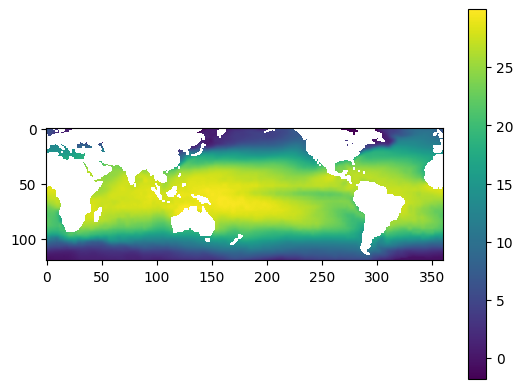

In [13]:
plt.imshow(np.flipud(sst_data.sel(latitude=slice(-60, 60), longitude=slice(0, 360)).SST.values[0]))
plt.colorbar()
plt.show()


In [18]:
ds = xr.Dataset(
    {
        "data": (["time", "channel", "lat", "lon"], mix_data)
    },
    coords={
        "time": time_dict['U925_90'][U925_idx],
        "channel": channels,
        "lat": sst_data.latitude.values,
        "lon": sst_data.longitude.values
    }
)

# Save to NetCDF file
ds.to_netcdf(directory + "mix_data_xarray.nc")


In [2]:
directory = '/home/mmotame1/climate-research/DVAE/dvae/dataset/multi_channel_data/'
data = xr.load_dataset(directory + "mix_data_xarray.nc")

In [17]:
data

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 839, channel: 9, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1955-02-14T21:00:00 ... 2024-12-16T09:...
  * channel  (channel) <U7 252B 'SST' 'OHC' 'U925_10' ... 'U925_75' 'U925_90'
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    data     (time, channel, lat, lon) float64 4GB -1.8 -1.8 ... 1.995 2.025

## Sandbox

In [20]:
data.data.values.shape

(839, 9, 180, 360)

In [22]:
ds = xr.Dataset(
    {
        "SST": (["time", "latitude", "longitude"], data.data.values[:,7,:,:])
    },
    coords={
        "time": data.time.values,
        "latitude": data.lat.values,
        "longitude": data.lon.values
    }
)

# Save to NetCDF file
ds.to_netcdf(directory + "U925_75_xarray.nc")

In [19]:
xr.load_dataset(directory + "U925_50_xarray.nc")

<xarray.Dataset> Size: 435MB
Dimensions:    (time: 839, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 7kB 1955-02-14T21:00:00 ... 2024-12-16T0...
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    SST        (time, latitude, longitude) float64 435MB 3.101 3.139 ... 0.4894

In [7]:
d = {'U925/U925_1deg_monq90_1940-2025':'U925_90', 
     'U925/U925_1deg_monq75_1940-2025':'U925_75', 
     'U925/U925_1deg_monq66_1940-2025':'U925_66', 
     'U925/U925_1deg_monmean_1940-2025':'U925_50', 
     'U925/U925_1deg_monq33_1940-2025':'U925_33', 
     'U925/U925_1deg_monq25_1940-2025':'U925_25',
     'U925/U925_1deg_monq10_1940-2025':'U925_10',
     'OHC_3m_1955-2025':'OHC',
     'HadISST/SST_1870-2024':'SST',
     }

dec_times = {'U925_90':True, 
             'U925_75':True, 
             'U925_66':True, 
             'U925_50':True, 
             'U925_33':True, 
             'U925_25':True, 
             'U925_10':True, 
             'OHC':False, 
             'SST':False}

arr_dict = {}
time_dict = {}
for item in tqdm(d):
    if d[item] in ['OHC', 'SST']:
        data_path = '/home/mmotame1/climate-research/DVAE/dvae/dataset/' + item + '.nc'
        file_data = xr.load_dataset(data_path, decode_times=dec_times[d[item]])
        print(file_data)
    
# data_path = '/home/mmotame1/climate-research/DVAE/dvae/dataset/' + 'OHC_3m_1955-2025' + '.nc'
# file_data = xr.load_dataset(data_path, decode_times=dec_times[d['OHC_3m_1955-2025']])
# file_data

 89%|████████▉ | 8/9 [00:00<00:00,  8.73it/s]

<xarray.Dataset> Size: 73MB
Dimensions:           (time: 281, bnds: 2, longitude: 360, latitude: 180,
                       depth: 1)
Coordinates:
  * time              (time) float32 1kB 1.452 4.5 7.5 ... 835.5 838.5 841.5
  * latitude          (latitude) float32 720B -89.5 -88.5 -87.5 ... 88.5 89.5
  * longitude         (longitude) float32 1kB -3.153e+18 4.583e-41 ... 4.583e-41
Dimensions without coordinates: bnds, depth
Data variables:
    climatology_bnds  (time, bnds) float64 4kB 0.0 3.0 3.0 ... 840.0 840.0 843.0
    lon_bnds          (longitude, bnds) float32 3kB -180.0 -179.0 ... 180.0
    lat_bnds          (latitude, bnds) float32 1kB -90.0 -89.0 ... 89.0 90.0
    crs               int32 4B 1
    OHC               (time, depth, latitude, longitude) float32 73MB nan ......
Attributes: (12/47)
    CDI:                           Climate Data Interface version 2.0.4 (http...
    Conventions:                   CF-1.6
    institution:                   National Oceanographic Data Ce

100%|██████████| 9/9 [00:09<00:00,  1.09s/it]

<xarray.Dataset> Size: 482MB
Dimensions:    (time: 1860, longitude: 360, latitude: 180)
Coordinates:
  * time       (time) float32 7kB 0.0 1.0 2.0 ... 1.857e+03 1.858e+03 1.859e+03
  * longitude  (longitude) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables:
    SST        (time, latitude, longitude) float32 482MB nan nan ... -1.8 -1.8
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Dec 16 11:46:20 2024: cdo settaxis,1870-01-15,00:00:00,...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...


In [20]:
mix_data.shape

(839, 9, 180, 360)